# Introduction 

This project is about **prediction** with **reduced** dataset. 

We will see through jupyter notebook all the steps to predict a price of a property with a reduced dataset. We have to load a dataset of houses prices from a real estate dataframe. Among the data , we would see each house associated with features and it price. 



# Load the data and overview

In [121]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from numpy import linalg as LA
import matplotlib.pyplot as plt

from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns

In [122]:
df = pd.read_csv('/content/sample_data/houses-prices.csv',index_col=0)

In [123]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Analyze of the data

> These data are data from a real estate study. They show all the features related to property and their price. In this project, we want to prediction a price for a property having only a few features. These feature that we want to know can be find by correlation. The more their are corrolated to the price the more accurate we can predict it. 

In this part, we will then analyze them and find these correlation. 

## Sale price analyse

In [124]:
# Correlation of all features with the target column " set price" 
df.corr()['SalePrice']

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [125]:
#df.info()

# De-categorisation 

Transform categoricalvalue into numerical

Indexation of value

In [126]:
# Identify the Categorical features
columns_str=['MSZoning','Street','Alley',
            'LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
             'Condition1','Condition2','BldgType','HouseStyle',
            'RoofStyle','RoofMatl','Exterior1st',"Exterior2nd","MasVnrType","ExterQual",
            'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
            'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','Electrical',
            'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish',
            'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
            'SaleType','SaleCondition']

col_bin=["CentralAir"]

In [127]:
# make a dataframe with the categorical key and the numerical key

str_keys=pd.DataFrame(columns=columns_str)
max_len=0
my_list=[]

#find the max number of unique category
for i in columns_str:
    unique_len=len(df[i].unique())
    if unique_len>max_len:
        max_len=unique_len

#add all value in in matrix format with : categorical value and nan
for i in columns_str:
    temp=[]
    for u in range(max_len):
        if u >= len(df[i].unique()):
            temp.append(np.nan)
        else:
            temp.append(df[i].unique()[u])
    my_list.append(temp)

In [128]:
#the result
np.asarray(my_list)

array([['RL', 'RM', 'C (all)', ..., 'nan', 'nan', 'nan'],
       ['Pave', 'Grvl', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'Grvl', 'Pave', ..., 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Shed', 'Gar2', ..., 'nan', 'nan', 'nan'],
       ['WD', 'New', 'COD', ..., 'nan', 'nan', 'nan'],
       ['Normal', 'Abnorml', 'Partial', ..., 'nan', 'nan', 'nan']],
      dtype='<U7')

In [129]:
#create the data frame with all categorcal value
str_keys=pd.DataFrame(columns=columns_str)
for i,u in enumerate(columns_str):
    str_keys[u]=np.asarray(my_list[i])

In [130]:
#the result
str_keys.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,nan,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
1,RM,Grvl,Grvl,IR1,Bnk,NoSeWa,FR2,Mod,Veenker,Feedr,Artery,2fmCon,1Story,Hip,WdShngl,MetalSd,MetalSd,None,TA,Gd,CBlock,TA,Gd,Gd,ALQ,BLQ,GasW,Gd,FuseF,TA,Min1,TA,Detchd,Unf,Fa,Fa,N,Ex,MnPrv,Shed,New,Abnorml
2,C (all),nan,Pave,IR2,Low,nan,Corner,Sev,Crawfor,PosN,RRNn,Duplex,1.5Fin,Gambrel,Metal,Wd Sdng,Wd Shng,Stone,Ex,Fa,BrkTil,Ex,nan,Mn,Unf,nan,Grav,TA,FuseA,Ex,Maj1,Gd,BuiltIn,Fin,Gd,nan,P,Fa,GdWo,Gar2,COD,Partial
3,FV,nan,nan,IR3,HLS,nan,CulDSac,nan,NoRidge,Artery,Feedr,TwnhsE,1.5Unf,Mansard,WdShake,HdBoard,HdBoard,BrkCmn,Fa,Po,Wood,nan,Fa,Av,Rec,ALQ,Wall,Fa,FuseP,Fa,Min2,Fa,CarPort,nan,nan,Gd,nan,Gd,GdPrv,Othr,ConLD,AdjLand
4,RH,nan,nan,nan,nan,nan,FR3,nan,Mitchel,RRAe,PosN,Twnhs,SFoyer,Flat,Membran,BrkFace,Plywood,nan,nan,Ex,Slab,Fa,Po,nan,BLQ,Rec,OthW,Po,Mix,nan,Mod,Ex,nan,nan,Ex,Po,nan,nan,MnWw,TenC,ConLI,Alloca


In [131]:
#replace the categorical value by the index of the value in the data frame
for ind,col in enumerate(df.columns):
    if col in columns_str:
        num=str_keys[col].dropna().index
        val=str_keys[col].dropna().values
        df.iloc[:,ind]=df[col].replace(val,num)
    

In [132]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,0,65.0,8450,0,NaN,0,0,0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0,0,0.0,196.0,0,0,0,0.0,0.0,0.0,0.0,706,0.0,0,150,856,0,0,Y,0.0,856,854,0,1710,1,0,2,1,3,1,0,8,0,0,NaN,0.0,2003.0,0.0,2,548,0.0,0.0,0,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,0,0,208500
2,20,0,80.0,9600,0,NaN,0,0,0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1,1,1.0,0.0,1,0,1,0.0,0.0,1.0,1.0,978,0.0,0,284,1262,0,0,Y,0.0,1262,0,0,1262,0,1,2,0,3,1,1,6,0,1,1.0,0.0,1976.0,0.0,2,460,0.0,0.0,0,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,0,0,181500
3,60,0,68.0,11250,0,NaN,1,0,0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0,0,0.0,162.0,0,0,0,0.0,0.0,2.0,0.0,486,0.0,0,434,920,0,0,Y,0.0,920,866,0,1786,1,0,2,1,3,1,0,6,0,1,1.0,0.0,2001.0,0.0,2,608,0.0,0.0,0,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,0,0,223500
4,70,0,60.0,9550,0,NaN,1,0,0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2,2,1.0,0.0,1,0,2,1.0,1.0,0.0,1.0,216,0.0,0,540,756,0,1,Y,0.0,961,756,0,1717,1,0,1,0,3,1,0,7,0,1,2.0,1.0,1998.0,1.0,3,642,0.0,0.0,0,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,0,1,140000
5,60,0,84.0,14260,0,NaN,1,0,0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0,0,0.0,350.0,0,0,0,0.0,0.0,3.0,0.0,655,0.0,0,490,1145,0,0,Y,0.0,1145,1053,0,2198,1,0,2,1,4,1,0,9,0,1,1.0,0.0,2000.0,0.0,3,836,0.0,0.0,0,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,0,0,250000


Now that we have only numerical value we can make an analysis on all our data

In [133]:
df.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,91.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1452.000000,1460.000000,1460.000000,1460.000000,1423.000000,1423.000000,1422.000000,1423.000000,1460.000000,1422.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1459.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,770.000000,1379.000000,1379.000000,1379.000000,1460.000000,1460.000000,1379.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7.000000,281.000000,54.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000
mean,56.897260,0.340411,70.049958,10516.828082,0.004110,1.450549,0.408219,0.195205,0.000685,0.596575,0.062329,9.478082,0.383562,0.034247,0.444521,1.144521,6.099315,5.575342,1971.267808,1984.865753,0.267808,0.065068,2.203425,2.532192,0.802342,103.685262,0.720548,0.148630,0.726712,0.724526,0.146170,0.720816,1.767393,443.639726,0.436006,46.549315,567.240411,1057.429452,0.039041,0.854795,0.156271,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,0.720548,6.517808,0.172603,0.613014,1.776623,0.522843,1978.506164,0.949239,1.767123,472.980137,0.074692,0.072516,0.102740,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,2.142857,1.729537,1.166667,43.489041,6.321918,2007.815753,0.234932,0.35000,180921.195890
std,42.300571,0.798309,24.284752,9981.264932,0.063996,0.500305,0.582296,0.642010,0.026171,1.010359,0.276232,5.837783,1.208607,0.374191,1.068108,1.324754,1.382997,1.112799,30.202904,20.645407,0.611903,0.539603,2.507095,2.662342,0.630202,181.066207,0.574763,0.440222,0.831177,0.815641,0.575885,1.137971,1.618287,456.098091,1.313514,161.319273,441.866955,438.705324,0.306179,0.959501,0.530529,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.706371,1.625393,0.717214,0.644666,0.871138,0.907168,24.689725,0.747733,0.747315,213.804841,0.398934,0.443260,0.365201,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,0.899735,0.924749,0.574620,496.123024,2.703626,1.328095,0.804553,0.88787,79442.502883
min,20.000000,0.000000,21.000000,1300.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,

In [134]:
df.corr()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,0.286937,-0.386347,-0.139781,0.024969,0.369373,-0.115361,-0.018947,-0.022844,-0.069160,-0.025672,0.181163,-0.034756,0.023822,0.770840,0.080782,0.032628,-0.059316,0.027850,0.040581,-0.099083,-0.024630,0.061310,0.045042,-0.066396,0.022936,-0.039352,0.011163,-0.019650,-0.125380,0.011774,0.064257,-0.097445,-0.069836,-0.042260,-0.065649,-0.140759,-0.238518,0.031321,0.019458,-0.044884,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,-0.019633,0.040380,-0.012157,-0.045569,-0.060155,0.145511,0.085072,0.035994,-0.040110,-0.098672,0.034570,0.009088,0.025973,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,0.203677,0.050909,0.291979,-0.007683,-0.013585,-0.021407,0.012874,-0.015047,-0.084284
MSZoning,0.286937,1.000000,-0.248800,-0.161640,0.039678,0.644996,-0.167918,-0.013396,-0.011167,-0.094747,-0.043444,-0.067889,-0.026021,0.016014,0.271750,-0.047199,-0.015122,-0.026962,-0.062684,0.033050,-0.088537,-0.049864,-0.063732,-0.025637,0.068372,-0.040722,-0.018093,0.017808,0.011181,-0.003547,0.067928,-0.072977,0.013978,-0.150204,-0.086463,-0.086788,0.012159,-0.175826,0.012889,-0.035643,0.084726,-0.227642,0.119662,0.074114,-0.061209,-0.111509,-0.070463,0.011160,0.014871,-0.085901,0.073459,-0.030523,-0.089983,-0.029668,-0.194000,0.048817,0.105359,0.029842,0.004863,-0.077273,-0.057814,0.044460,0.025421,0.117402,-0.133311,0.109211,0.075025,-0.045145,-0.067541,-0.029301,NaN,-0.083901,0.011154,-0.021573,0.022231,-0.010621,0.058948,0.068705,-0.116047
LotFrontage,-0.386347,-0.248800,1.000000,0.426095,0.040886,-0.379265,0.231878,0.096766,NaN,0.150762,0.088345,-0.123530,0.083031,0.041819,-0.471250,-0.036986,0.251646,-0.059213,0.123349,0.088866,0.191217,0.238808,-0.015645,-0.016729,-0.007163,0.193458,-0.014731,-0.055054,-0.093245,0.063358,-0.066590,0.101981,-0.076481,0.233633,0.014385,0.049900,0.132644,0.392075,-0.022364,-0.098509,-0.068195,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.031075,0.352096,-0.013661,0.266639,-0.014312,-0.072910,0.070250,0.000623,0.285691,0.344997,-0.042716,-0.039203,-0.073334,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.133012,0.047296,0.004823,0.003368,0.011200,0.007450,0.006370,0.072517,0.351799
LotArea,-0.139781,-0.161640,0.426095,1.000000,0.197131,-0.437644,0.315484,0.258792,0.010123,0.160976,0.436868,0.043191,0.033795,0.030878,-0.211111,-0.008187,0.105806,-0.005636,0.014228,0.013788,0.137369,0.162496,0.085558,0.061748,0.066289,0.104160,0.014713,-0.018784,-0.006544,-0.011832,-0.021096,0.071060,-0.018347,0.214103,0.072094,0.111170,-0.002618,0.260833,0.022623,-0.003581,-0.043388,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.007505,0.190015,0.034551,0.271364,-0.018955,-0.032390,-0.024947,0.052875,0.154871,0.180403,-0.009089,-0.025427,-0.002964,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.289391,0.129134,-0.030826,0.038068,0.001205,-0.014261,-0.013882,0.000199,0.263843
Street,0.024969,0.039678,0.040886,0.197131,1.000000,NaN,0.010129,0.097236,-0.001682,0.004458,0.179360,0.053445,0.023914,-0.005881,0.023392,0.025328

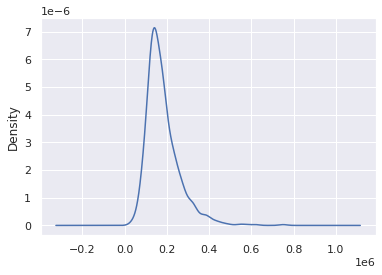

In [135]:
df['SalePrice'].plot.density()

# Price prediction with selected features 

We decide now to choose a problematic that will struture our project. We want to find out the more correlated features that would help us to predict the price of a property. This is a regression problem that we would try to solve in a few steps. 

First we will set up a really simple algorithm and test our data. We want to use a basic model. 

## Simple algorithm

> Here, we want to try a naive way to first get a firstscore. We will use the simplest algorithm and raw data. And we will train it and find a score using train test spliting. 

We want to measure the performances by scoring the prediction, time to train and time to predict. 

### test on raw data


We choose to use a Linear regression which is one of the most basics method. 

We choose to used the linear regression method from sklearn. 

In [136]:
#formating the data frame
df=df.apply(pd.to_numeric, errors='coerce')
df=df.fillna(0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,0,65.0,8450,0,0.0,0,0,0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0,0,0.0,196.0,0,0,0,0.0,0.0,0.0,0.0,706,0.0,0,150,856,0,0,0.0,0.0,856,854,0,1710,1,0,2,1,3,1,0,8,0,0,0.0,0.0,2003.0,0.0,2,548,0.0,0.0,0,0,61,0,0,0,0,0.0,0.0,0.0,0,2,2008,0,0,208500
2,20,0,80.0,9600,0,0.0,0,0,0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1,1,1.0,0.0,1,0,1,0.0,0.0,1.0,1.0,978,0.0,0,284,1262,0,0,0.0,0.0,1262,0,0,1262,0,1,2,0,3,1,1,6,0,1,1.0,0.0,1976.0,0.0,2,460,0.0,0.0,0,298,0,0,0,0,0,0.0,0.0,0.0,0,5,2007,0,0,181500
3,60,0,68.0,11250,0,0.0,1,0,0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0,0,0.0,162.0,0,0,0,0.0,0.0,2.0,0.0,486,0.0,0,434,920,0,0,0.0,0.0,920,866,0,1786,1,0,2,1,3,1,0,6,0,1,1.0,0.0,2001.0,0.0,2,608,0.0,0.0,0,0,42,0,0,0,0,0.0,0.0,0.0,0,9,2008,0,0,223500
4,70,0,60.0,9550,0,0.0,1,0,0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2,2,1.0,0.0,1,0,2,1.0,1.0,0.0,1.0,216,0.0,0,540,756,0,1,0.0,0.0,961,756,0,1717,1,0,1,0,3,1,0,7,0,1,2.0,1.0,1998.0,1.0,3,642,0.0,0.0,0,0,35,272,0,0,0,0.0,0.0,0.0,0,2,2006,0,1,140000
5,60,0,84.0,14260,0,0.0,1,0,0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0,0,0.0,350.0,0,0,0,0.0,0.0,3.0,0.0,655,0.0,0,490,1145,0,0,0.0,0.0,1145,1053,0,2198,1,0,2,1,4,1,0,9,0,1,1.0,0.0,2000.0,0.0,3,836,0.0,0.0,0,192,84,0,0,0,0,0.0,0.0,0.0,0,12,2008,0,0,250000


In [137]:
#split in test and train data set and X Y With X the 80th features and Y the Sale price
df2 = df.copy()

In [138]:
size=len(df)
X_train=np.asarray(df2.drop(columns='SalePrice').iloc[:int(0.7*size),:])
Y_train=np.asarray(df2['SalePrice'].iloc[:int(0.7*size)])

X_test=np.asarray(df2.drop(columns='SalePrice').iloc[int(0.7*size):,:])
Y_test=np.asarray(df2['SalePrice'].iloc[int(0.7*size):])

In [139]:
#Fit the model
reg = LinearRegression().fit(X_train, Y_train)
#test the model
reg.score(X_test, Y_test)


0.5906150615222985

We see that the score is really low, 0.58 is not enought our model isn't good

## Naive way with reduced dataset 

> As we saw above, our algorithm is not efficient enough. We will here reduce our dataset using a naive way to do it. We will select the features we want. here again we want to find the final score and compare it. 

In order to keep fetures which really matters for our prediction, we will select only certain fetures thanks to a true or false list. This list would be a naive way of choosing the right to keep. 

We use the SelectFromModel but we could have chosen others. This one is more mathematics. 

We drop first our target. And define it as the target. 

In [140]:
df3 = df.copy()

In [141]:
df3_features = df3.drop(columns='SalePrice')
df3_target = df3['SalePrice']


df3_columns = list(df.columns)
df3_columns2 = df3_columns.remove('SalePrice')
print(df3_columns)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

We apply again the Linear Regression as an estimator. 

In [142]:
# Choose and load the estimator / model
linear_regression_estimator = LinearRegression()

# Load the selector
select_from_model_selector = SelectFromModel(linear_regression_estimator, max_features=5, threshold=-np.inf)

# Fit the selector on data
select_from_model_selector.fit(df3_features, df3_target)



SelectFromModel(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                max_features=5, norm_order=1, prefit=False, threshold=-inf)

Let's create a new dataframe with the columns corresponding to all the features, their coefficient associated and if they are selected or not (with True or False). 

In [143]:
# Gather the features selected
df3_features_selected = pd.DataFrame(df3_columns,columns=["features"])

# display the coeff, the features and the selected status
df3_features_selected['coeff'] = select_from_model_selector.estimator_.coef_
df3_features_selected['is_selected'] = select_from_model_selector.get_support()


Now, we can see which features would be relevant to select. We observe that these features are the most correlate to the sale price : 
- KitchenAbvGr : kitchens abode grade
- OverallQual : rates the orverall material and finish of the house
- Utilities 
- PoolQC : Pool quality
- Street

In [144]:

df3_features_selected.sort_values('is_selected', ascending = False,inplace=True)
print(df3_features_selected)


         features          coeff  is_selected
51   KitchenAbvGr  -19156.555265         True
4          Street  -35546.432132         True
16    OverallQual   13778.796588         True
8       Utilities  -57438.019312         True
71         PoolQC -189383.616736         True
..            ...            ...          ...
27      ExterCond     -13.469172        False
26      ExterQual    3538.416445        False
25     MasVnrArea      29.194704        False
24     MasVnrType    3963.940674        False
78  SaleCondition     644.828087        False

[79 rows x 3 columns]


Let's try hte RFE on our dataset. The RFE is the recursive feature elimination. It removes each features based on their coef score provide by the estimator (ie LR or SVC) : the feature with the lowest coef is removed. Improvement is'nt based on the model score, but on the model coef calculation : The RFE choice the features depending on model, it's not always relevant. 

In [145]:
# Load the selector on a defined number of feature to select
rfe_selector = RFE(linear_regression_estimator, n_features_to_select=4)
# fit on train set
fited_rfe_selector = rfe_selector.fit(df3_features, df3_target)


In [146]:

df3_features_selected['ranking'] = fited_rfe_selector.ranking_
df3_features_selected.sort_values('ranking', inplace=True)

print(df3_features_selected)

        features         coeff  is_selected  ranking
47  BsmtHalfBath  -2033.319015        False        1
22   Exterior1st   -702.603469        False        1
53  TotRmsAbvGrd   3712.782908        False        1
55    Fireplaces   -268.663609        False        1
17   OverallCond   6272.255190        False        2
..           ...           ...          ...      ...
1       MSZoning    345.176820        False       72
27     ExterCond    -13.469172        False       73
8      Utilities -57438.019312         True       74
34  BsmtFinType2  -1798.295698        False       75
42      1stFlrSF     27.088236        False       76

[79 rows x 4 columns]


Let's see about the score with our new dataset. 

In [147]:
scaler = StandardScaler()

#calculating the mean and variance
scaler.fit(df3_features)

#removing the mean and scaling to unit variance
scaled_df3_features = scaler.transform(df3_features)


In [148]:
# Do the procedure to create the 4 datasets, train the model and score its prediction

scaled_df3_features_train, scaled_df3_features_test, df3_target_train, df3_target_test = train_test_split(scaled_df3_features, df3_target, test_size=0.20, random_state=42)

linear_svc_model = LinearSVC(dual=False,max_iter=1000)
linear_svc_model.fit(scaled_df3_features_train,df3_target_train)

print(f1_score(df3_target_test,linear_svc_model.predict(scaled_df3_features_test),average=None))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

The score is really bad, we will find a solution to increase it. The score is a bit imroved from the first one. We have now 0.6666

# Improve the score 

## First try

We will try now to improve our score and our algorithm. We would also measure for each algorithm the performance. 

In [149]:
df4 = df.copy()

# we check that there is no nan and inf
df4[~df4.isin([np.nan, np.inf, -np.inf]).any(1)]

# we put everything in float
df4= df4.astype(float)

print(df4)

      MSSubClass  MSZoning  LotFrontage  ...  SaleType  SaleCondition  SalePrice
Id                                       ...                                    
1           60.0       0.0         65.0  ...       0.0            0.0   208500.0
2           20.0       0.0         80.0  ...       0.0            0.0   181500.0
3           60.0       0.0         68.0  ...       0.0            0.0   223500.0
4           70.0       0.0         60.0  ...       0.0            1.0   140000.0
5           60.0       0.0         84.0  ...       0.0            0.0   250000.0
...          ...       ...          ...  ...       ...            ...        ...
1456        60.0       0.0         62.0  ...       0.0            0.0   175000.0
1457        20.0       0.0         85.0  ...       0.0            0.0   210000.0
1458        70.0       0.0         66.0  ...       0.0            0.0   266500.0
1459        20.0       0.0         68.0  ...       0.0            0.0   142125.0
1460        20.0       0.0  

In [150]:
df4_features = df4.drop('SalePrice', axis=1)
df4_target = df4['SalePrice']
print(df4_features)

      MSSubClass  MSZoning  LotFrontage  ...  YrSold  SaleType  SaleCondition
Id                                       ...                                 
1           60.0       0.0         65.0  ...  2008.0       0.0            0.0
2           20.0       0.0         80.0  ...  2007.0       0.0            0.0
3           60.0       0.0         68.0  ...  2008.0       0.0            0.0
4           70.0       0.0         60.0  ...  2006.0       0.0            1.0
5           60.0       0.0         84.0  ...  2008.0       0.0            0.0
...          ...       ...          ...  ...     ...       ...            ...
1456        60.0       0.0         62.0  ...  2007.0       0.0            0.0
1457        20.0       0.0         85.0  ...  2010.0       0.0            0.0
1458        70.0       0.0         66.0  ...  2010.0       0.0            0.0
1459        20.0       0.0         68.0  ...  2010.0       0.0            0.0
1460        20.0       0.0         75.0  ...  2008.0       0.0  

We drop the columns if the present the same values

In [151]:
#df4_features = df4.drop('MSZoning')
#, 'SaleType', 'Street', 'Alley', 'LandContour', 'Utilities','LandSlope'

In [152]:
#using linalg from numpy, extract the eigen values from the avocado dataset

#values = LA.eigvals(df4_features.corr())



These error would ask us to drop all the columns with the same result. Because a lot of columns were converted to integer when there were strings, there are columns with zeros through each id. Unfortunately we would have to drop a lot of columns.  

In [153]:
# using Matplotlib or Seaborn, draw a scree plot of the previous calculated eigen values
"""
plt.scatter(range(1,values.size+1),values)
plt.plot(range(1,values.size+1),values)
plt.hlines(1, 0, values.size, colors='r')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()"""


"\nplt.scatter(range(1,values.size+1),values)\nplt.plot(range(1,values.size+1),values)\nplt.hlines(1, 0, values.size, colors='r')\nplt.title('Scree Plot')\nplt.xlabel('Factors')\nplt.ylabel('Eigenvalue')\nplt.grid()\nplt.show()"

How many to keep if we want to reduce the dataset?

In [154]:
df4_features_columns = list(df4_features.columns)

# use the train_test_split function to create 4 dataset :
# avocado_features_train, avocado_features_test, avocado_target_train, avocado_target_test
df4_features_train, df4_features_test, df4_target_train, df4_target_test = train_test_split(df4_features, df4_target, test_size=0.20, random_state=42)

# initiate the LinearSVC model
linear_svc_model = LinearSVC()
# fit the data on the train data and target
linear_svc_model.fit(df4_features_train,df4_target_train)
#Score the prediction score on the test data and target
#print(linear_svc_model.score(df4_features_test,df4_target_test))

df4_target_predicted = linear_svc_model.predict(df4_features_test)

print(f1_score(df4_target_test, df4_target_predicted, average=None))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 In this contexte, the algorithm doesn't perform well
The linear SVC use distance calculation to perform its prediction.
we are going to normalize or data in order to reduce the value of the distance


## Second try

In [155]:


# use the StandardScaler to remove the mean and scaling data to unit variance
scaler = StandardScaler()
#calculating the mean and variance
scaler.fit(df4_features)
#removing the mean and scaling to unit variance
scaled_df4_features = scaler.transform(df4_features)

# create the FactorAnalysis and fit it on the dataset in order to have a new dataset with only 6 columns
factor_analysis_df4 = FactorAnalysis(n_components = 6).fit(scaled_df4_features)
# create a transformed_scaled_avocado_features dataset using the FactorAnalysis previously created
transformed_scaled_df4_features = factor_analysis_df4.transform(scaled_df4_features)

# Do the procedure to create the 4 datasets, train the model and score its prediction
transformed_scaled_df4_features_train, transformed_scaled_df4_features_test, df4_target_train, df4_target_test = train_test_split(transformed_scaled_df4_features, df4_target, test_size=0.20, random_state=42)

linear_svc_model = LinearSVC()
linear_svc_model.fit(transformed_scaled_df4_features_train,df4_target_train)

#print(linear_svc_model.score(transformed_scaled_avocado_features_test,avocado_target_test))

print(f1_score(df4_target_test, linear_svc_model.predict(transformed_scaled_df4_features_test), average=None))


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04166667 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Third try : Random Forest 

In [156]:
df5 = df.copy()

In [157]:
df5.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Thanks to the previous steps, we would choose the slected features the more adequat to our goals. 

In [158]:
RF = RandomForestRegressor()

In [159]:
RF.fit(df5[['BsmtHalfBath', 'Exterior1st', 'TotRmsAbvGrd']], df5['SalePrice'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [160]:
df['SalePrice_predicted'] = RF.predict(df[['BsmtHalfBath', 'Exterior1st', 'TotRmsAbvGrd']])

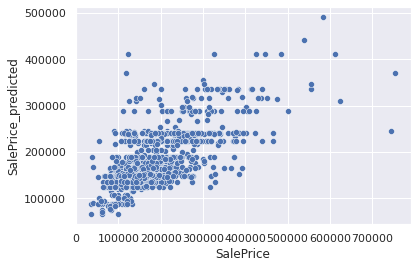

In [161]:
sns.scatterplot(data=df, x="SalePrice", y="SalePrice_predicted")

In [162]:
(df['SalePrice_predicted'] / df['SalePrice']).describe()

count    1460.000000
mean        1.089833
std         0.357591
min         0.329264
25%         0.894732
50%         1.030774
75%         1.214749
max         4.980760
dtype: float64

In [163]:
df['Good_price'] = (df['SalePrice_predicted'] /df['SalePrice']).between(0.75, 1.25)

In [164]:
df['Good_price'].value_counts()

True     1013
False     447
Name: Good_price, dtype: int64

The random forest gave us a pretty good result. With a large tolerance of 25%, it could find 1013 true predicted price and 447 wrong ones. This predict function could be maybe an interesting option. 

In [183]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_predicted,Good_price
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.001734,-0.534148,0.006139,-0.000021,-1.003439,-0.652805,-1.203942,-0.473596,-1.0,-0.584405,-0.816844,-0.278115,-0.262582,-0.244585,-0.389638,-0.652158,0.470902,-0.464614,0.034786,0.042545,-0.715251,-0.223472,-0.350555,-0.357247,-2.002433,0.002844,-2.181152,-0.766944,-1.051902,-1.067723,-0.440034,-0.550877,-0.655070,0.001261,-0.251992,-0.001789,-0.002137,-0.001047,-0.416458,-0.928477,...,-0.002052,0.002661,-0.002472,0.000705,2.134145,-1.009323,1.433014,2.440248,0.200696,-0.959349,-1.444098,0.561032,-0.335544,-1.475028,-0.789205,-0.623845,0.000652,-1.558411,0.416983,0.001641,-0.468428,-0.368546,-0.770327,-0.005999,0.003267,-0.005877,-0.003967,-0.004844,-0.001709,-0.406822,-0.528921,-0.713137,-0.000177,-0.591266,0.104458,-0.362938,-0.443986,4.369881e-06,0.000021,1.440276
2,-0.020621,-0.534148,0.018622,-0.000009,-1.003439,-0.652805,-1.203942,-0.473596,-1.0,0.395195,-0.816844,-0.248772,0.422007,-0.244585,-0.389638,-0.082349,-0.051925,1.958018,0.005188,-0.020800,-0.715251,-0.223472,-0.191460,-0.216165,0.507054,-0.003157,0.845922,-0.766944,0.395579,-1.067723,-0.440034,0.233787,-0.274791,0.002569,-0.251992,-0.001789,-0.001451,0.001063,-0.416458,-0.928477,...,0.000665,-0.001821,-0.002472,-0.000918,-1.579624,16.533667,1.433014,-1.513983,0.200696,-0.959349,0.560068,-0.195998,-0.335544,0.931163,0.053075,-0.623845,0.000521,-1.558411,0.416983,-0.000284,-0.468428,-0.368546,-0.770327,0.012970,-0.010629,-0.005877,-0.003967,-0.004844,-0.001709,-0.406822,-0.528921,-0.713137,-0.000177,-0.180847,-0.462488,-0.362938,-0.443986,9.171192e-08,-0.000008,1.440276
3,0.001734,-0.534148,0.008636,0.000007,-1.003439,-0.652805,1.745312,-0.473596,-1.0,-0.584405,-0.816844,-0.278115,-0.262582,-0.244585,-0.389638,-0.652158,0.470902,-0.464614,0.032593,0.040199,-0.715251,-0.223472,-0.350555,-0.357247,-2.002433,0.001803,-2.181152,-0.766944,-1.051902,-1.067723,-0.440034,1.018451,-0.655070,0.000204,-0.251992,-0.001789,-0.000682,-0.000714,-0.416458,-0.928477,...,-0.001623,0.002724,-0.002472,0.000980,2.134145,-1.009323,1.433014,2.440248,0.200696,-0.959349,-1.444098,-0.195998,-0.335544,0.931163,0.053075,-0.623845,0.000643,-1.558411,0.416983,0.002954,-0.468428,-0.368546,-0.770327,-0.005999,-0.001062,-0.005877,-0.003967,-0.004844,-0.001709,-0.406822,-0.528921,-0.713137,-0.000177,0.366379,0.104458,-0.362938,-0.443986,6.746641e-06,0.000003,1.440276
4,0.007323,-0.534148,0.001978,-0.000010,-1.003439,-0.652805,1.745312,-0.473596,-1.0,1.374795,-0.816844,-0.219429,-0.262582,-0.244585,-0.389638,-0.652158,0.470902,-0.464614,-0.061683,-0.034877,-0.715251,-0.223472,-0.032364,-0.075083,0.507054,-0.003157,0.845922,-0.766944,1.843059,0.444281,2.648665,-0.550877,-0.274791,-0.001094,-0.251992,-0.001789,-0.000140,-0.001566,-0.416458,0.157722,...,-0.001349,0.002146,-0.002472,0.000730,2.134145,-1.009323,-1.861790,-1.513983,0.200696,-0.959349,-1.444098,0.182517,-0.335544,0.931163,0.895355,0.639419,0.000628,0.179771,2.207559,0.003697,-0.468428,-0.368546,-0.770327,-0.005999,-0.002656,0.066937,-0.003967,-0.004844,-0.001709,-0.406822,-0.528921,-0.713137,-0.00017

# PCA

The PCA intent is to looking for correlated features in order to separates then in uncorralted values called component. Its allow us to discover wich component (ie group of features) that impact the most the variance of the target.

## First try

In [166]:
from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [167]:
#fist step clean the data
def clean(x):
    if x == 'N':
        return 0
    else :
        return 1

In [168]:
#fill na
df['CentralAir']=df['CentralAir'].apply(clean)
df=df.fillna(0)


In [169]:
# To make a good PCA we firt need to center and reduce the data
#this is a standard decomposition to have a normal centred reduced density of value aroud 0 
#with this the PCA will be much more efficient.


for i in df.columns:
    df[i]=df[i]-df[i].mean()
    df[i]=df[i]/df[i].var()

In [170]:
#Prepare X
df_temp=df.drop(columns="SalePrice")

In [171]:
#Format X
X=[]
df_temp=df_temp.fillna(0)
for i in df_temp.columns:
    new_array = np.asarray(df_temp[i]).astype(type('float', (float,), {}))
    X.append(new_array)
type(new_array[0])


float

In [172]:
X=np.asarray(X).T

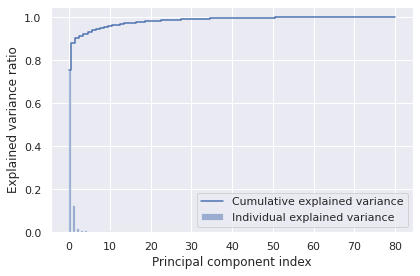

In [173]:
#
# Scale the dataset; This is very important before you apply PCA
#
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)

pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the 2 first componnent are equale to 85% of the explain variable and the other are really small against them so we choose to decompse our matrix In 2 dimention

In [174]:
pca = PCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)

In [175]:
#separe Train test

In [176]:
X_train=X_transformed[:int(len(X_transformed)*0.7)]
X_test=X_transformed[int(len(X_transformed)*0.7):]

Y_train=df.iloc[:int(len(X_transformed)*0.7),79]
Y_test=df.iloc[int(len(X_transformed)*0.7):,79]

In [177]:
#model regressor linear

In [178]:
#Fit the model
reg = LinearRegression().fit(X_train, Y_train)
#test the model
reg.score(X_test, Y_test)


0.00037651681722117303

The score is really really really bad

## Second try

In [179]:
df6 = df5.copy()


In [180]:
scaler = StandardScaler()
#calculating the mean and variance
scaler.fit(df3_features)
#removing the mean and scaling to unit variance
scaled_df_features = scaler.transform(df3_features)


We take again the most efficient algorithm that we created with a score of 0.6666. 

In [184]:
# Create a PCA model 
pca_for_df6 = PCA()
# fit the scaled data in this model
pca_for_df6 = pca_for_df6.fit(scaled_df_features)
# Create a new dataset composed by the 16 previously calculated components
transformed_scaled_pca_features = pca_for_df6.transform(scaled_df_features)

# use the train_test_split function to create 4 dataset :
# avocado_features_train, avocado_features_test, avocado_target_train, avocado_target_test
transformed_scaled_pca_features_train, transformed_scaled_pca_features_test, df6_target_train, df6_target_test = train_test_split(transformed_scaled_pca_features, df3_target, test_size=0.20, random_state=42)

# initiate the LinearSVC model
linear_svc_model = LinearSVC()
# fit the data on the train data and target
linear_svc_model.fit(transformed_scaled_pca_features_train,df6_target_train)
#Score the prediction score (F1-score) on the test data and target

target_predicted = linear_svc_model.predict(transformed_scaled_pca_features_test)


print(f1_score(df6_target_test, target_predicted, average =None))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Our score remain the same. Let's select only the most interesting features thanks a graph. 

Text(0, 0.5, 'Percentages of explained variance')

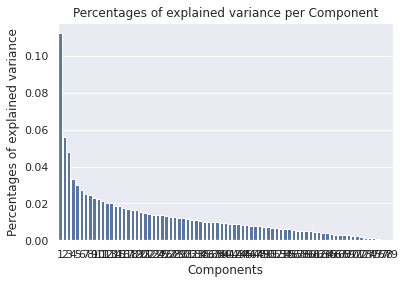

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set()

variance_ratios = pca_for_df6.explained_variance_ratio_
components = np.arange(1, pca_for_df6.explained_variance_ratio_.size+1)


sns.barplot( x=components,y=variance_ratios,color="b")
plt.title('Percentages of explained variance per Component')
plt.xlabel('Components')
plt.ylabel('Percentages of explained variance')

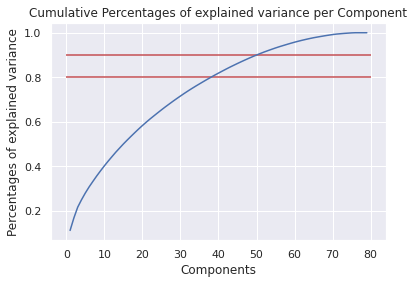

In [186]:
sns.lineplot( x=components,y=variance_ratios.cumsum(axis=0),color="b")
plt.title('Cumulative Percentages of explained variance per Component')
plt.xlabel('Components')
plt.ylabel('Percentages of explained variance')
plt.hlines(0.8, 0, 80, colors='r')
plt.hlines(0.9, 0, 80, colors='r')

Through all the components the more relevant to keep are the ones until 50. 

In [188]:
# Create a PCA model 
pca_for_df6 = PCA(n_components=50)
# fit the scaled data in this model
pca_for_df6 = pca_for_df6.fit(scaled_df_features)
# Create a new dataset composed by the 16 previously calculated components
transformed_scaled_pca_features = pca_for_df6.transform(scaled_df_features)

# use the train_test_split function to create 4 dataset :
# avocado_features_train, avocado_features_test, avocado_target_train, avocado_target_test
transformed_scaled_pca_features_train, transformed_scaled_pca_features_test, df6_target_train, df6_target_test = train_test_split(transformed_scaled_pca_features, df3_target, test_size=0.20, random_state=42)

# initiate the LinearSVC model
linear_svc_model = LinearSVC()
# fit the data on the train data and target
linear_svc_model.fit(transformed_scaled_pca_features_train,df6_target_train)
#Score the prediction score (F1-score) on the test data and target

target_predicted = linear_svc_model.predict(transformed_scaled_pca_features_test)

print(f1_score(df6_target_test, target_predicted, average =None))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [190]:
dataset_reduced = pd.DataFrame(data=transformed_scaled_pca_features)

print(dataset_reduced)

            0         1         2   ...        47        48        49
0     2.325955 -2.654202  0.767217  ... -0.197476  0.188808 -0.255813
1     0.424905 -0.198288 -1.445335  ... -0.397213 -0.834228  0.956657
2     2.978325 -2.227794  0.270433  ...  0.237542  0.856004 -0.394889
3    -0.257079  0.967923  1.111154  ...  0.229771  0.250649  0.502210
4     5.262473 -0.779596  1.139035  ...  0.255740  0.469066 -0.306474
...        ...       ...       ...  ...       ...       ...       ...
1455  1.097104 -1.709192  1.668221  ... -0.313769  0.639130  0.149807
1456  1.311457  2.712327 -2.175229  ...  0.118915 -0.479324  1.658525
1457 -1.101335  3.346756  2.812014  ... -0.270385 -0.557443  0.698027
1458 -2.363212  0.253565 -3.406279  ...  0.426713 -0.008689 -0.342088
1459 -0.917360  0.867086 -2.360942  ...  0.378369 -0.267645  0.029275

[1460 rows x 50 columns]


In [192]:
features_columns = list(df3_features.columns)

In [193]:
component_0 = pd.DataFrame(data=pca_for_df6.components_[0])

component_0["columns"] = features_columns

print(component_0)

           0        columns
0  -0.017006     MSSubClass
1  -0.043129       MSZoning
2   0.069355    LotFrontage
3   0.078741        LotArea
4  -0.012777         Street
..       ...            ...
74 -0.015589        MiscVal
75  0.018716         MoSold
76 -0.013912         YrSold
77  0.020150       SaleType
78  0.055813  SaleCondition

[79 rows x 2 columns]


We have now our reduced dataset without loosing information which can help us to solve our problem. 

# Final step

# Conclusion

To conclude, our score were so low that we could achieve our goal to predict the price of a property using other features. The different tests for selecting features didn't give us to same result, so we decided to keep both and the test them in the tries after. We tried several ways to predict the price with the different features selected and we couldn't find a proper score, at least a score that could satisfy us. But the random forest try was an intresting way and could possibily work better than the linear and the svd. 

After all these tries, we wanted to set the PCA. We did also two tries with the PCA, one with a really bad result and other one which works perfectly. We could reduce our dataset without loosing information. We could resume information and make linear combination. 

At the end, we learn a lot through this project. We could challenge us by trying diffenrent ways in achieve our goal. We didn't succeed but we would be happy to keep trying even after the dead-line. 